In [1]:
import pandas as pd


In [2]:
# path to fasta file with restriction enzyme recognition sequence:
fasta_file_re = "lab_enzymes.fa"
# path to genome file
genome = "../genome.fa"

!seqkit locate --bed -f $fasta_file_re $genome -j 34 -F > lab_enzymes.bed
!awk -F "\t" '{print $1 "\t" $2 "\t" $4}' lab_enzymes.bed > lab_enzymes_3c.bed

In [3]:
enzyme_list = pd.read_csv("lab_enzymes_3c.bed", sep="\t", names=['Chr', 'cutsite', 'name'])
enzyme_list

,Chr,cutsite,name
0,I,28159,NheI
1,I,73641,NheI
2,I,77863,NheI
3,I,91402,NheI
4,I,110705,NheI
...,...,...,...
2624180,MtDNA,4870,HindIII-HF
2624181,MtDNA,1907,HindIII-HF
2624182,MtDNA,1054,HindIII-HF
2624183,MtDNA,9249,PstI-HF


In [4]:
chromosomes = enzyme_list['Chr'].unique()
print(chromosomes)
enzymes = enzyme_list['name'].unique()
print(enzymes)

Chrom_sizes = {
    'I' : 15072434,
    'II' : 15279421,
    'III' : 13783801,
    'IV' : 17493829,
    'V' : 20924180,
    'X' : 17718942,
    'MtDNA' : 13794
}
print(Chrom_sizes)

['I' 'II' 'III' 'IV' 'V' 'X' 'MtDNA']
['NheI' 'PvuII' 'SacII' 'ApaI' 'ApaLI' 'NaeI' 'SalI-HF' 'HindIII-HF'
 'BamHI-HF' 'AflII' 'EcoRI-HF' 'NdeI' 'KpnI-HF' 'XhoI' 'BglII' 'SacI-HF'
 'PstI-HF' 'NcoI' 'PmlI' 'BsmAI' 'MboI' 'SapI' 'EagI-HF' 'HpaII' 'XbaI'
 'EcoRV-HF' 'DraI' 'DpnI']
{'I': 15072434, 'II': 15279421, 'III': 13783801, 'IV': 17493829, 'V': 20924180, 'X': 17718942, 'MtDNA': 13794}


In [5]:
enzyme_list.query('Chr == "I"')

,Chr,cutsite,name
0,I,28159,NheI
1,I,73641,NheI
2,I,77863,NheI
3,I,91402,NheI
4,I,110705,NheI
...,...,...,...
414036,I,3974,DpnI
414037,I,3749,DpnI
414038,I,3680,DpnI
414039,I,2674,DpnI


In [12]:
import matplotlib.pyplot as plt
import numpy as np

print(enzymes)
def digest(zyme1, zyme2):
    all_chr_fragment_lengths = []
    for chr in chromosomes:
        enzyme_1_df = enzyme_list.query('Chr == @chr & name == @zyme1')
        enzyme_2_df = enzyme_list.query('Chr == @chr & name == @zyme2')
        # Querying the chromosomes and enzymes provided and return a new dataframe
        list_of_enzyme_1_cutsites = enzyme_1_df['cutsite'].to_list()
        list_of_enzyme_2_cutsites = enzyme_2_df['cutsite'].to_list()
        # Making lists for the two enzyme cutting sites
        all_cutsites_list = list_of_enzyme_1_cutsites + list_of_enzyme_2_cutsites
        all_cutsites_list.append(1)
        all_cutsites_list.append(Chrom_sizes[chr])
        # Merging the two lists into one and add "1" and "chromosome length" to the list
        set_of_all_cutsites = set(all_cutsites_list)
        all_cutsites_list = list(set_of_all_cutsites)
        # Render the cut sites unique before sorting
        all_cutsites_list.sort()

        fragment_length = []
        last_position = 0
        for i in all_cutsites_list:
            if(last_position == 0):
                last_position = i
            else:
                fragment_length.append(i - last_position)
                last_position = i
        for item in fragment_length:
            all_chr_fragment_lengths.append(item)
        # Making the difference between the adjacent two items in the list 
    
    all_chr_fragment_lengths.sort()
    return all_chr_fragment_lengths

def fig1(zyme1, zyme2):
    all_chr_fragment_lengths = digest(zyme1, zyme2)
    genomelength = sum(all_chr_fragment_lengths)
    
    
    def percent_to_size(n):
        totalcount = 0
        cutoff_threshold = 0
        for i in all_chr_fragment_lengths:
            if totalcount <= n * 0.01 * genomelength:
                totalcount += i
            else:
                cutoff_threshold = i
                break
        return cutoff_threshold
    
    def size_to_percent(n):
        below_cutoff = 0
        for i in all_chr_fragment_lengths:
            if i <= n:
                below_cutoff += i
        return round(below_cutoff/genomelength*100)
    
    def array_proportion(n):
        above_cutoff = 0
        for i in all_chr_fragment_lengths:
            if i >= n:
                above_cutoff += i
        return (str(round(5000000 * 100 / (5000000 + above_cutoff))) + "%")
    
    plt.hist(all_chr_fragment_lengths, bins=5000, color="slategray")
    plt.yscale('log')
    plt.xlim(0, 15000)
    plt.vlines(x=3000, ymin=0, ymax=100, colors="tab:red", linestyles="dotted", linewidth=2)
    plt.text(3000, 100, str(size_to_percent(3000)) + "%" + "\n" + "(SRE XS)", color="tab:red")
    plt.vlines(x=percent_to_size(95), ymin=0, ymax=100, colors="tab:blue", linestyles="dotted", linewidth=2)
    plt.text(percent_to_size(95), 100, "95%", color="tab:blue")
    plt.vlines(x=10000, ymin=0, ymax=100, colors="gold", linestyles="dotted", linewidth=2)
    plt.text(10000, 100, str(size_to_percent(10000)) + "%" + "\n" + "(SRE)", color="gold")
    plt.xlabel("Fragment length (base)")
    plt.ylabel("Fragment count")
    if zyme1 == zyme2:
        plt.title(str(zyme1))
        plt.savefig("1 " + zyme1 + " gDNA digestion", dpi=500)
    else:
        plt.title(str(zyme1 + ' & ' + zyme2))
        plt.savefig("1 " + zyme1 + " & " + zyme2 + " gDNA digestion", dpi=500)
    plt.show()

['NheI' 'PvuII' 'SacII' 'ApaI' 'ApaLI' 'NaeI' 'SalI-HF' 'HindIII-HF'
 'BamHI-HF' 'AflII' 'EcoRI-HF' 'NdeI' 'KpnI-HF' 'XhoI' 'BglII' 'SacI-HF'
 'PstI-HF' 'NcoI' 'PmlI' 'BsmAI' 'MboI' 'SapI' 'EagI-HF' 'HpaII' 'XbaI'
 'EcoRV-HF' 'DraI' 'DpnI']


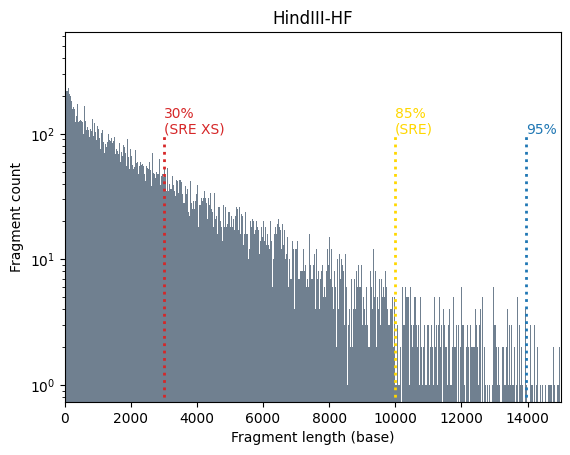

In [15]:
fig1("HindIII-HF", "HindIII-HF")
# Generate your figure 1 here. If there is only one enzyme conducting digestion, please make the input as two identical enzymes as shown here.

In [8]:
import matplotlib.pyplot as plt
print(enzymes)
def fig2(zyme1, zyme2):
    digestion = digest(zyme1, zyme2)

    def size_to_percent(fragments, n):
        above_cutoff = 0
        for i in fragments:
            if i >= n:
                above_cutoff += i
        return round(5000000 * 100/(above_cutoff + 5000000))
    
    comparisonlist = ["No selection", "SRE XS (3 kb)", "SRE (10 kb)"]
    percentagelist = [5, size_to_percent(digestion, 3000), size_to_percent(digestion, 10000)]
    bar_colors = ["tab:blue", "tab:blue", "gold"]
    
    fig, ax = plt.subplots()
    bar_container = ax.bar(comparisonlist, percentagelist, color=bar_colors)
    ax.bar_label(bar_container, fmt=lambda x: str(x) + "%")
    ax.set_ylim(0, 100)
    if zyme1 == zyme2:
        ax.set(ylabel="Array percentage in size-selected DNA", xlabel = "Selection after " + zyme1 + " digestion")
        plt.savefig("2 Array percentage after digestion by " + zyme1, dpi=500)
    else:
        ax.set(ylabel="Array percentage in size-selected DNA", xlabel = "Selection after " + zyme1 + " & " + zyme2 + " digestion")
        plt.savefig("2 Array percentage after digestion by " + zyme1 + " & " + zyme2, dpi=500)
    return percentagelist

['NheI' 'PvuII' 'SacII' 'ApaI' 'ApaLI' 'NaeI' 'SalI-HF' 'HindIII-HF'
 'BamHI-HF' 'AflII' 'EcoRI-HF' 'NdeI' 'KpnI-HF' 'XhoI' 'BglII' 'SacI-HF'
 'PstI-HF' 'NcoI' 'PmlI' 'BsmAI' 'MboI' 'SapI' 'EagI-HF' 'HpaII' 'XbaI'
 'EcoRV-HF' 'DraI' 'DpnI']


[5, 13, 82]

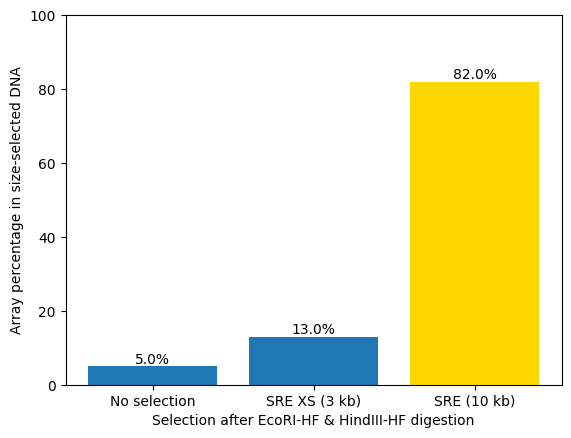

In [9]:
fig2("EcoRI-HF", "HindIII-HF")
# Generate your figure 2 here. If there is only one enzyme conducting digestion, please make the input as two identical enzymes.